In [1]:
%load_ext autoreload
%autoreload 2

import os
import shutil

import omegaconf
import hydra
import numpy as np
import pylab as plt
import swyft.lightning as sl
import torch
from lensx.logging_utils import log_post_plots, log_target_plots, log_train_plots
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from lensx.nn.subN.utils import print_dict

# plt.switch_backend("agg")
plt.rcParams['figure.facecolor'] = 'white'


In [2]:
cfg = omegaconf.OmegaConf.load("config_uniform_norm_blobs.yaml")
from lensx.nn.subN.plot import plt_imshow
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top
from tqdm.notebook import tqdm as tqdm
import matplotlib.colors


In [3]:
def check_obs(cfg):
    try:   torch.load(cfg.inference.obs_path)
    except FileNotFoundError: print('No mock generated!')
        
check_obs(cfg)

No mock generated!


/home/eliasd/.pyenv/versions/3.9.7/envs/lens-3.9.7/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 1/1 [00:00<00:00, 1316.89it/s]


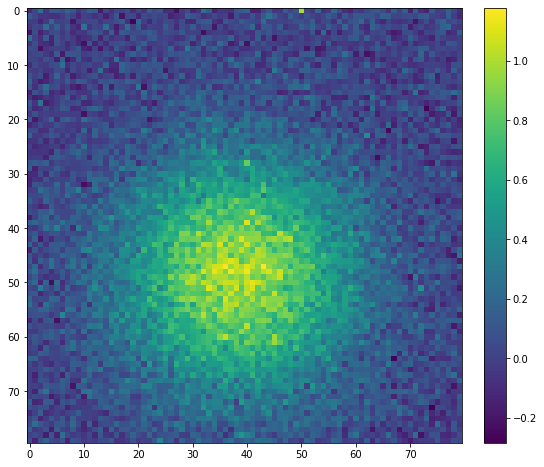

In [4]:
simulator = hydra.utils.instantiate(cfg.simulation.model)
sample = simulator.sample(1,)
plt_imshow(sample['img'], cbar = True);

In [5]:
# sample = simulator.sample(100)['z_sub']
# sample_M = sample[:,:,0]
# sample;

# plt.hist(np.count_nonzero(sample_M, axis  = 1), bins = np.arange(-0.5, 6.5) )
# plt.show()

In [6]:
def simulate(cfg):
    # Loading simulator (potentially bounded)
    simulator = hydra.utils.instantiate(cfg.simulation.model)

    # Generate or load training data & generate datamodule
    train_samples = sl.file_cache(
        lambda: simulator.sample(cfg.simulation.store.store_size),
        cfg.simulation.store.path,
    )[: cfg.simulation.store.train_size]
    datamodule = sl.SwyftDataModule(
        store=train_samples,
        model=simulator,  # Adds noise on the fly. `None` uses noise in store.
        batch_size=cfg.estimation.batch_size,
        num_workers=cfg.estimation.num_workers,
    )

    return datamodule, simulator
datamodule, simulator = simulate(cfg)

In [7]:
def load(cfg, simulator):
    print('Loading trained network')
    tbl = pl_loggers.TensorBoardLogger(
        save_dir=cfg.tensorboard.save_dir,
        name=cfg.tensorboard.name,
        version=cfg.tensorboard.version,
        default_hp_metric=False,
    )
    logdir = (
        tbl.experiment.get_logdir()
    )  # Directory where all logging information and checkpoints etc are stored
    
#     epoch=09-val_loss=106464.16.ckpt

    checkpoints = os.listdir( os.path.join(logdir, 'checkpoint') )
    if 'best.ckpt' in checkpoints:
        best_ckpt = 'best.ckpt'
    else:
        best_idx = np.argmax(list(map(int, [checkpoint[6:8] for checkpoint in checkpoints])))
        best_ckpt = checkpoints[best_idx]
    print(f'best checkpoint is {best_ckpt}')
    
    checkpoint = torch.load(
        os.path.join(logdir, f'checkpoint/{best_ckpt}'), map_location='cpu'
    )

    network = hydra.utils.instantiate(cfg.estimation.network, cfg)
    network.load_state_dict(checkpoint["state_dict"])

    train_samples = torch.load(cfg.simulation.store.path)
    
    trainer = sl.SwyftTrainer(accelerator=cfg.estimation.accelerator, gpus=1)
    trainer.setup(None)
    
    datamodule = sl.SwyftDataModule(store=train_samples, model=simulator)
    datamodule.setup()
    
    trainer.model = network
    
    return network, trainer, tbl, datamodule

def analyse(cfg, datamodule):
    # Setting up tensorboard logger, which defines also logdir (contains trained network)
    tbl = pl_loggers.TensorBoardLogger(
        save_dir=cfg.tensorboard.save_dir,
        name=cfg.tensorboard.name,
        version=cfg.tensorboard.version,
        default_hp_metric=False,
    )
    logdir = (
        tbl.experiment.get_logdir()
    )  # Directory where all logging information and checkpoints etc are stored

    # Load network and train (or re-load trained network)
    network = hydra.utils.instantiate(cfg.estimation.network, cfg)
#     network = ImgSegmNetwork(cfg, 1)

    lr_monitor = LearningRateMonitor(logging_interval="step")
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=cfg.estimation.early_stopping.min_delta,
        patience=cfg.estimation.early_stopping.patience,
        verbose=False,
        mode="min",
    )
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath=logdir + "/checkpoint/",
        filename="{epoch:02d}-{val_loss:.2f}",
        save_top_k=3,
        mode="min",
    )
    trainer = sl.SwyftTrainer(
        accelerator=cfg.estimation.accelerator,
        gpus=1,
        max_epochs=cfg.estimation.max_epochs,
        logger=tbl,
        callbacks=[lr_monitor, early_stop_callback, checkpoint_callback],
    )
    best_checkpoint = logdir + "/checkpoint/best.ckpt"
    if not os.path.isfile(best_checkpoint):
        trainer.fit(network, datamodule)
        shutil.copy(checkpoint_callback.best_model_path, best_checkpoint)
        trainer.test(network, datamodule)
    else:
        print('realoding network?')
        trainer.fit(network, datamodule, ckpt_path=best_checkpoint)

    return network, trainer, tbl

# network, trainer, tbl = analyse(cfg, datamodule)
network, trainer, tbl, datamodule = load(cfg, simulator)

Loading trained network
best checkpoint is best.ckpt
Prior,    M_frac    in subhalo log10 mass range
3.26e-05, 8.33e-02:    [8.000 - 8.250]
3.26e-05, 8.33e-02:    [8.250 - 8.500]
3.26e-05, 8.33e-02:    [8.500 - 8.750]
3.26e-05, 8.33e-02:    [8.750 - 9.000]
3.26e-05, 8.33e-02:    [9.000 - 9.250]
3.26e-05, 8.33e-02:    [9.250 - 9.500]
3.26e-05, 8.33e-02:    [9.500 - 9.750]
3.26e-05, 8.33e-02:    [9.750 - 10.000]
3.26e-05, 8.33e-02:    [10.000 - 10.250]
3.26e-05, 8.33e-02:    [10.250 - 10.500]
3.26e-05, 8.33e-02:    [10.500 - 10.750]
3.26e-05, 8.33e-02:    [10.750 - 11.000]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


# Interpret

In [8]:
def interpret(cfg, simulator, network, trainer, datamodule, tbl):
    hydra.utils.call(
        cfg.inference.interpreter, cfg, simulator, network, trainer, datamodule, tbl
    )

# interpret(cfg, simulator, network, trainer, datamodule, tbl)

# Interpret again

In [9]:
import os
import numpy as np
import pylab as plt
import torch
import swyft.lightning as sl

from lensx.nn.subN.interpret import IsotonicRegressionCalibration, PostData
from lensx.nn.subN.logging_utils_subN import LogIRC, LogPost, LogObs, LogBounds, LogSingleSub
from lensx.nn.subN.inference import Infer, Prior

In [10]:
logdir = tbl.experiment.get_logdir()

# Calculate expected n_sub
Ms = datamodule.predict_dataloader().dataset[:]['z_sub'][:,:,0]
n_sub_expect = torch.mean(torch.tensor(np.count_nonzero(Ms.numpy(), axis  = 1), dtype = torch.float32))
print(f'n_sub_expect = {n_sub_expect:.3f}\n')

# Loading the inference class and 
infer = Infer(simulator, network, datamodule, n_sub_expect)

n_sub_expect = 2.508

Prior,    M_frac    in subhalo log10 mass range
3.27e-05, 8.33e-02:    [8.000 - 8.250]
3.27e-05, 8.33e-02:    [8.250 - 8.500]
3.27e-05, 8.33e-02:    [8.500 - 8.750]
3.27e-05, 8.33e-02:    [8.750 - 9.000]
3.27e-05, 8.33e-02:    [9.000 - 9.250]
3.27e-05, 8.33e-02:    [9.250 - 9.500]
3.27e-05, 8.33e-02:    [9.500 - 9.750]
3.27e-05, 8.33e-02:    [9.750 - 10.000]
3.27e-05, 8.33e-02:    [10.000 - 10.250]
3.27e-05, 8.33e-02:    [10.250 - 10.500]
3.27e-05, 8.33e-02:    [10.500 - 10.750]
3.27e-05, 8.33e-02:    [10.750 - 11.000]


In [11]:
# Prior information necessary for loggers
prior, prior_grid = infer.calc_prior()[0], infer.prior_grid()
grid_coords = infer.get_grid_coords()
grid_low, grid_high = infer.grid_low, infer.grid_high

In [12]:
# # Simulations inference

# posts_norm, posts_unnorm, targets = infer.get_posts(datamodule.predict_dataloader(), cfg.inference.n_infer)
# torch.save(posts_norm, os.path.join(logdir, 'posts_norm.pt'))
# torch.save(posts_unnorm, os.path.join(logdir, 'posts_unnorm.pt'))
# torch.save(targets, os.path.join(logdir, 'targets.pt'))

posts_norm = torch.load(os.path.join(logdir, 'posts_norm.pt'))
posts_unnorm = torch.load(os.path.join(logdir, 'posts_unnorm.pt'))
targets       = torch.load(os.path.join(logdir, 'targets.pt'))

# posts = torch.load(os.path.join(logdir, 'posts_uncalib_old.pt'))
# # posts_unnorm = torch.load(os.path.join(logdir, 'posts_unnorm.pt'))
# targets       = torch.load(os.path.join(logdir, 'targets_old.pt'))

In [15]:
# Calibration
irc_norm = IsotonicRegressionCalibration(posts_norm, targets)    

irc_unnorm = IsotonicRegressionCalibration(posts_unnorm, targets)    


Calculating reliability curve: 100%|██████████| 313/313 [00:01<00:00, 252.75it/s]


In [14]:
assert 1 == 2

AssertionError: 

In [ ]:
plt.hist( (posts_norm / posts_unnorm).flatten().cpu().numpy() )
plt.yscale('log')

In [ ]:
posts_norm[0].flatten(), posts_unnorm[0].flatten()

In [ ]:
if np.random.randint(20) == 1

In [ ]:
values, edges = torch.histogram(posts.cpu(), 
                                bins = torch.logspace(torch.log10(posts.min()), torch.log10(posts.max()), 100)
                               )

In [ ]:
plt.stairs(values, edges)
plt.xscale('log')
plt.yscale('log')

In [ ]:
posts = posts.cpu()
targets = targets.cpu()

In [ ]:
post_data_uncalib = PostData(posts, targets, prior)

In [ ]:
relicurve = post_data_uncalib.get_relicurve()

In [ ]:
alpha_edges = post_data_uncalib.alpha_edges.cpu()

In [ ]:
plt.plot(torch.diff(alpha_edges))
plt.yscale('log')

In [ ]:
relicurve.min()

In [ ]:
relicurve

In [ ]:
relicurve[0] == 0.

In [ ]:
plt.stairs(relicurve.cpu(), post_data_uncalib.alpha_edges.cpu())
plt.plot((0., 1.), (0, 1), 'k:', label = r'$N_{sub,obs}$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(alpha_edges.min(), 1e-5)
plt.ylim(relicurve.min(), 1e-5)

In [ ]:
plt.stairs(relicurve.cpu(), post_data_uncalib.alpha_edges.cpu())
plt.plot((0., 1.), (0, 1), 'k:', label = r'$N_{sub,obs}$')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1e-2, 1)
# plt.ylim(1e-2, 1)

In [ ]:
assert 1 == 2

In [ ]:
# Calibration
irc_norm = IsotonicRegressionCalibration(posts_norm, targets)    
posts_norm_calib = irc_norm.calibrate(posts_norm)
torch.save(posts_norm_calib, os.path.join(logdir, 'posts_norm_calib.pt'))

irc_unnorm = IsotonicRegressionCalibration(posts_unnorm, targets)    
posts_unnorm_calib = irc_unnorm.calibrate(posts_unnorm)
torch.save(posts_unnorm_calib, os.path.join(logdir, 'posts_unnorm_calib.pt'))

In [ ]:
# Log simulation inference
LogPost(tbl, posts_norm, targets, title = 'norm_uncalib').plot_all()
LogPost(tbl, posts_norm_calib, targets, title = 'norm_calib').plot_all()
LogIRC(tbl, irc_norm, title = 'norm_calibration').plot()

LogPost(tbl, posts_unnorm, targets, title = 'unnorm_uncalib').plot_all()
LogPost(tbl, posts_unnorm_calib, targets, title = 'unnorm_calib').plot_all()
LogIRC(tbl, irc_unnorm, title = 'unnorm_calibration').plot()

In [ ]:
test_sim = simulator.sample(1)

test_post_uncalib = infer.get_post(test_sim)[0].squeeze(0)
test_sim = infer.squeeze_obs(test_sim)
test_post = irc_norm.calibrate(test_post_uncalib)

log_obs = LogObs(tbl, test_sim, test_post, prior, grid_coords)
log_obs.plot_obs()

In [ ]:
tbl.experiment.flush()
print("logdir:", logdir)

In [ ]:
assert 1 == 2

# Lavalamp plot

100%|██████████| 1/1 [00:00<00:00, 4619.28it/s]


100%|██████████| 1/1 [00:00<00:00, 4415.06it/s]


100%|██████████| 1/1 [00:00<00:00, 4534.38it/s]


tensor([[[10.6704,  0.2611,  0.3117],
         [10.1182,  2.2958, -0.3046],
         [ 9.8354, -1.2874,  1.7304],
         [10.4134,  2.2098,  2.0943],
         [10.6879,  2.1064, -0.9152]]])


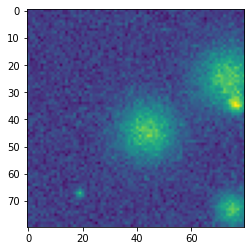

In [31]:
for _ in range(10000):
    test_sim = simulator.sample(1)
    if (test_sim['z_sub'][0,:,0] > 9.5).sum() > 4:
        break
# test_sim = simulator.sample(1)

print(test_sim['z_sub'])
plt.imshow(test_sim['img'][0])
plt.show()

In [32]:
test_post_uncalib = infer.get_post(test_sim)[0].squeeze(0)
test_sim = infer.squeeze_obs(test_sim)
# test_post = test_post_uncalib
test_post = irc_norm.calibrate(test_post_uncalib)

In [ ]:
assert 1 == 2

In [ ]:
log_obs = LogObs(None, test_sim, test_post_uncalib, prior, grid_coords)
log_obs.plot_all()

In [ ]:
posts_unnorm.max()

In [ ]:
test_sim

In [ ]:
plt_imshow(test_post, x = 20, y = 20, cbar = True);

In [ ]:
irc = irc_norm

In [ ]:
test_post_uncalib = infer.get_post(test_sim)[0].squeeze(0)
test_sim = infer.squeeze_obs(test_sim)
test_post = irc_norm.calibrate(test_post_uncalib)

log_obs = LogObs(None, test_sim, test_post, prior, grid_coords)
log_obs.plot_obs()

# 2D plot

In [ ]:
# logobs = LogObs(None, test_sim, test_post, prior, grid_coords)

# for zlog in [False, True]:
#     logobs.plot_msc(zlog = zlog, 
#                     plot_true = True,
#                     title = rf'Sum posterios $= {torch.sum(test_post).item():.2f}$',
#                     vminmax = True,
#                    );

In [ ]:
# 
# m_centers, m_edges, xy_centers, xy_edges = grid_coords
# X, Y, Z = torch.meshgrid(xy_centers, xy_centers, m_centers)
# values = np.transpose(post, [2, 1, 0])

# z_sub = obs['z_sub'].numpy()
# z_sub = z_sub[np.sum(np.abs(z_sub), axis = 1) != 0] 
# M_sub, x_sub, y_sub = z_sub.T

# # values = values[:20, :20, :6]

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [34]:
def colormap(x):
    cmap = matplotlib.cm.get_cmap('viridis')(x)
    return [x, f'rgb{cmap[:-1]}']

norm = matplotlib.colors.Normalize()
colorscale = [colormap(i) for i in np.linspace(0, 1, 10)]

In [35]:
def lavalamp(post, obs, grid_coords):
    m_centers, m_edges, xy_centers, xy_edges = grid_coords
    X, Y, Z = torch.meshgrid(xy_centers, xy_centers, m_centers)
    values = np.transpose(post, [2, 1, 0])
    
    z_sub = obs['z_sub'].numpy()
    z_sub = z_sub[np.sum(np.abs(z_sub), axis = 1) != 0] 
    M_sub, x_sub, y_sub = z_sub.T
    
    im = np.array(obs['img'])
    im_x, im_y = im.shape
    x = np.linspace(grid_low[1], grid_high[1], im_x)
    y = np.linspace(grid_low[2], grid_high[2], im_y)
    z = np.ones(im.shape) * grid_low[0]
    
    

    fig = make_subplots(rows=1, cols=2,
                        specs=[[{'is_3d': True}, {'is_3d': True}]],
                        subplot_titles=['Normal scale', 'Logarithmic scale'],
                        )

    for ncol, v, cbar_x in zip([1, 2], [values, np.log10(values)], [-0.10, None]):
        fig.add_trace(go.Volume(
            x=X.flatten(),
            y=Y.flatten(),
            z=Z.flatten(),
            value=v.flatten(),
            surface_count = 20,
        #     opacity = 0.1,
            opacityscale = [[0, 0], [1, 0.9]],
            colorbar_x=cbar_x,
        ), 1, ncol)

        fig.add_trace(go.Scatter3d(
            x = x_sub,
            y = y_sub,
            z = M_sub,
            mode ='markers',
            marker = dict(
                color = 'red',
                symbol = 'x',
                size = 5,
            ),
        ), 1, ncol)

    fig.add_trace(go.Surface(x=x, y=y, z=z,
        surfacecolor=im, 
        colorscale=colorscale,
        showscale=False,
    #     lighting_diffuse=1,
    #     lighting_ambient=1,
    #     lighting_fresnel=1,
    #     lighting_roughness=1,
    #     lighting_specular=0.5,
    ), 1, 1)


    fig.update_layout(
        height = 800, 
        width = 1600, 
        title_text="Subhalo posteriors",
        scene = dict(
            xaxis=dict(title=r"x"),
            yaxis=dict(title=r"y"),
            zaxis=dict(title=r'M'),
        ),
        showlegend=False
    )
    
    return fig
    


version = 'blobs_12_v0_calib'
post, obs = test_post.cpu().numpy(), test_sim
fig = lavalamp(post, obs, grid_coords)
# fig.show()
fig.write_html(f"lavalamp_v{version}.html")

# Logarithmic relicurve

In [ ]:
assert 1 == 2

In [ ]:
DEVICE = 'cuda'

class Alpha():
    def __init__(self, posts, n_alpha = 50):
        self.n_alpha = n_alpha
        self.alpha_edges = torch.linspace(0, 1, n_alpha, device = DEVICE)#, dtype=torch.float64)
        self.alpha_centers = (self.alpha_edges[:-1] + self.alpha_edges[1:])/2
        
class LogAlpha():
    def __init__(self, posts, n_alpha = 50):
        self.n_alpha = n_alpha
        
        posts_min = torch.log10(posts.min())
        posts_max = torch.log10(posts.max())
        self.alpha_edges = torch.logspace(posts_min, posts_max, self.n_alpha, device = DEVICE)
        
        self.alpha_edges = torch.cat((
#             torch.tensor([0.], device = DEVICE),
            self.alpha_edges,
#             torch.tensor([1], device = DEVICE)
        ))
        
        self.n_alpha = len(self.alpha_edges)

        self.alpha_centers = (self.alpha_edges[:-1] + self.alpha_edges[1:])/2
        

class PostData(LogAlpha):
    def __init__(self, posts, targets, n_alpha = 50):
        super().__init__(posts = posts, n_alpha = n_alpha)
        self.posts = posts
        self.targets = targets
        
    def get_histogram(self):
        hist = torch.histogram(self.posts.flatten().cpu(), bins = self.alpha_edges.cpu())[0].to(DEVICE)
        return hist
    
    def get_relicurve(self, batch_size = 16):
        
        is_between_sum = torch.zeros_like(self.alpha_centers)
        
        for batch_idx in tqdm(range(int(np.ceil(len(self.posts) / batch_size))), desc='Calculating reliability curve'):
            i, j = batch_idx*batch_size, (batch_idx+1)*batch_size
            posts_alpha = torch.repeat_interleave(self.posts[i:j].unsqueeze(-1), self.n_alpha-1, dim = -1)
            targets_alpha = torch.repeat_interleave(self.targets[i:j].unsqueeze(-1), self.n_alpha-1, dim = -1)
        
            is_between = (posts_alpha > self.alpha_edges[:-1]) & (posts_alpha < self.alpha_edges[1:])
            is_between_sum += torch.sum(targets_alpha * is_between, dim = (0, 1, 2, 3))
        hist = self.get_histogram() 
        relicurve = is_between_sum/hist
        relicurve = torch.nan_to_num(relicurve)
        return relicurve, is_between_sum

In [ ]:
postdata = PostData(posts_uncalib, targets)

In [ ]:
relicurve, is_between_sum = postdata.get_relicurve()

In [ ]:
hist

In [ ]:
is_between_sum

In [ ]:
plt.stairs(is_between_sum.cpu(), postdata.alpha_edges.cpu())
# plt.plot((posts_min, posts_max ), (posts_min, posts_max ), 'k:')
plt.xscale('log')
plt.yscale('log')

In [ ]:
posts_min, posts_max = postdata.posts.min().cpu(), postdata.posts.max().cpu()

In [ ]:
plt.stairs(relicurve.cpu(), postdata.alpha_edges.cpu())
plt.plot((posts_min, posts_max ), (posts_min, posts_max ), 'k:')
plt.xscale('log')
plt.yscale('log')

In [ ]:
a   = torch.tensor([1e-10])
eps = torch.tensor([1e-17])

a + eps == a

In [ ]:
print(f'smallest posterior = {posts_uncalib.min()}, largest posterior = {posts_uncalib.max()}')


plt.stairs(hist.cpu(), postdata.alpha_edges.cpu())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted pixel posterior')
plt.ylabel('Counts')
plt.show()

print('>>> torch.finfo(torch.float32)', torch.finfo(torch.float32), sep = '\n')
